In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy import special
import scipy.stats as stats
from scipy.sparse import coo_matrix

In [47]:
data = pd.read_csv('user_edges.csv', index_col=False)
data = data.to_numpy()
edges =data[:, 1:3]
len(edges)

52954

In [48]:
column_to_be_added = np.ones(len(edges))
edges = np.hstack((edges, np.atleast_2d(column_to_be_added).T))
edges = edges.astype(int)

In [49]:
row  = edges[:, 0]
col  = edges[:, 1]
data = edges[:, 2]
#m = coo_matrix((data, (row, col)), shape=(len(edges), len(edges)))
m = coo_matrix((data, (row, col)), shape=(11149, 11149))
# Adjecency matrix
f = m.toarray()

In [50]:
suma = np.zeros(len(f))
for i in range(len(f)):
    suma[i] = np.sum(f[i])
cont = 0
for i in range(len(suma)):
    if suma[i] > 20:
        cont = cont+1
indices = np.zeros(cont)
contador = 0
for i in range(len(suma)):
    if suma[i] > 20:
        indices[contador] = i
        contador = contador+1

In [51]:
indices = indices.astype(int)
sliced = f[indices]
sliced =sliced[:, indices]

In [52]:
G = nx.Graph()

for i in range(len(sliced)):
    for j in range(len(sliced)):
        if sliced[i][j] == 1:
            G.add_edge(i,j)
    

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 493
Number of edges: 7475
Average degree:  30.3245


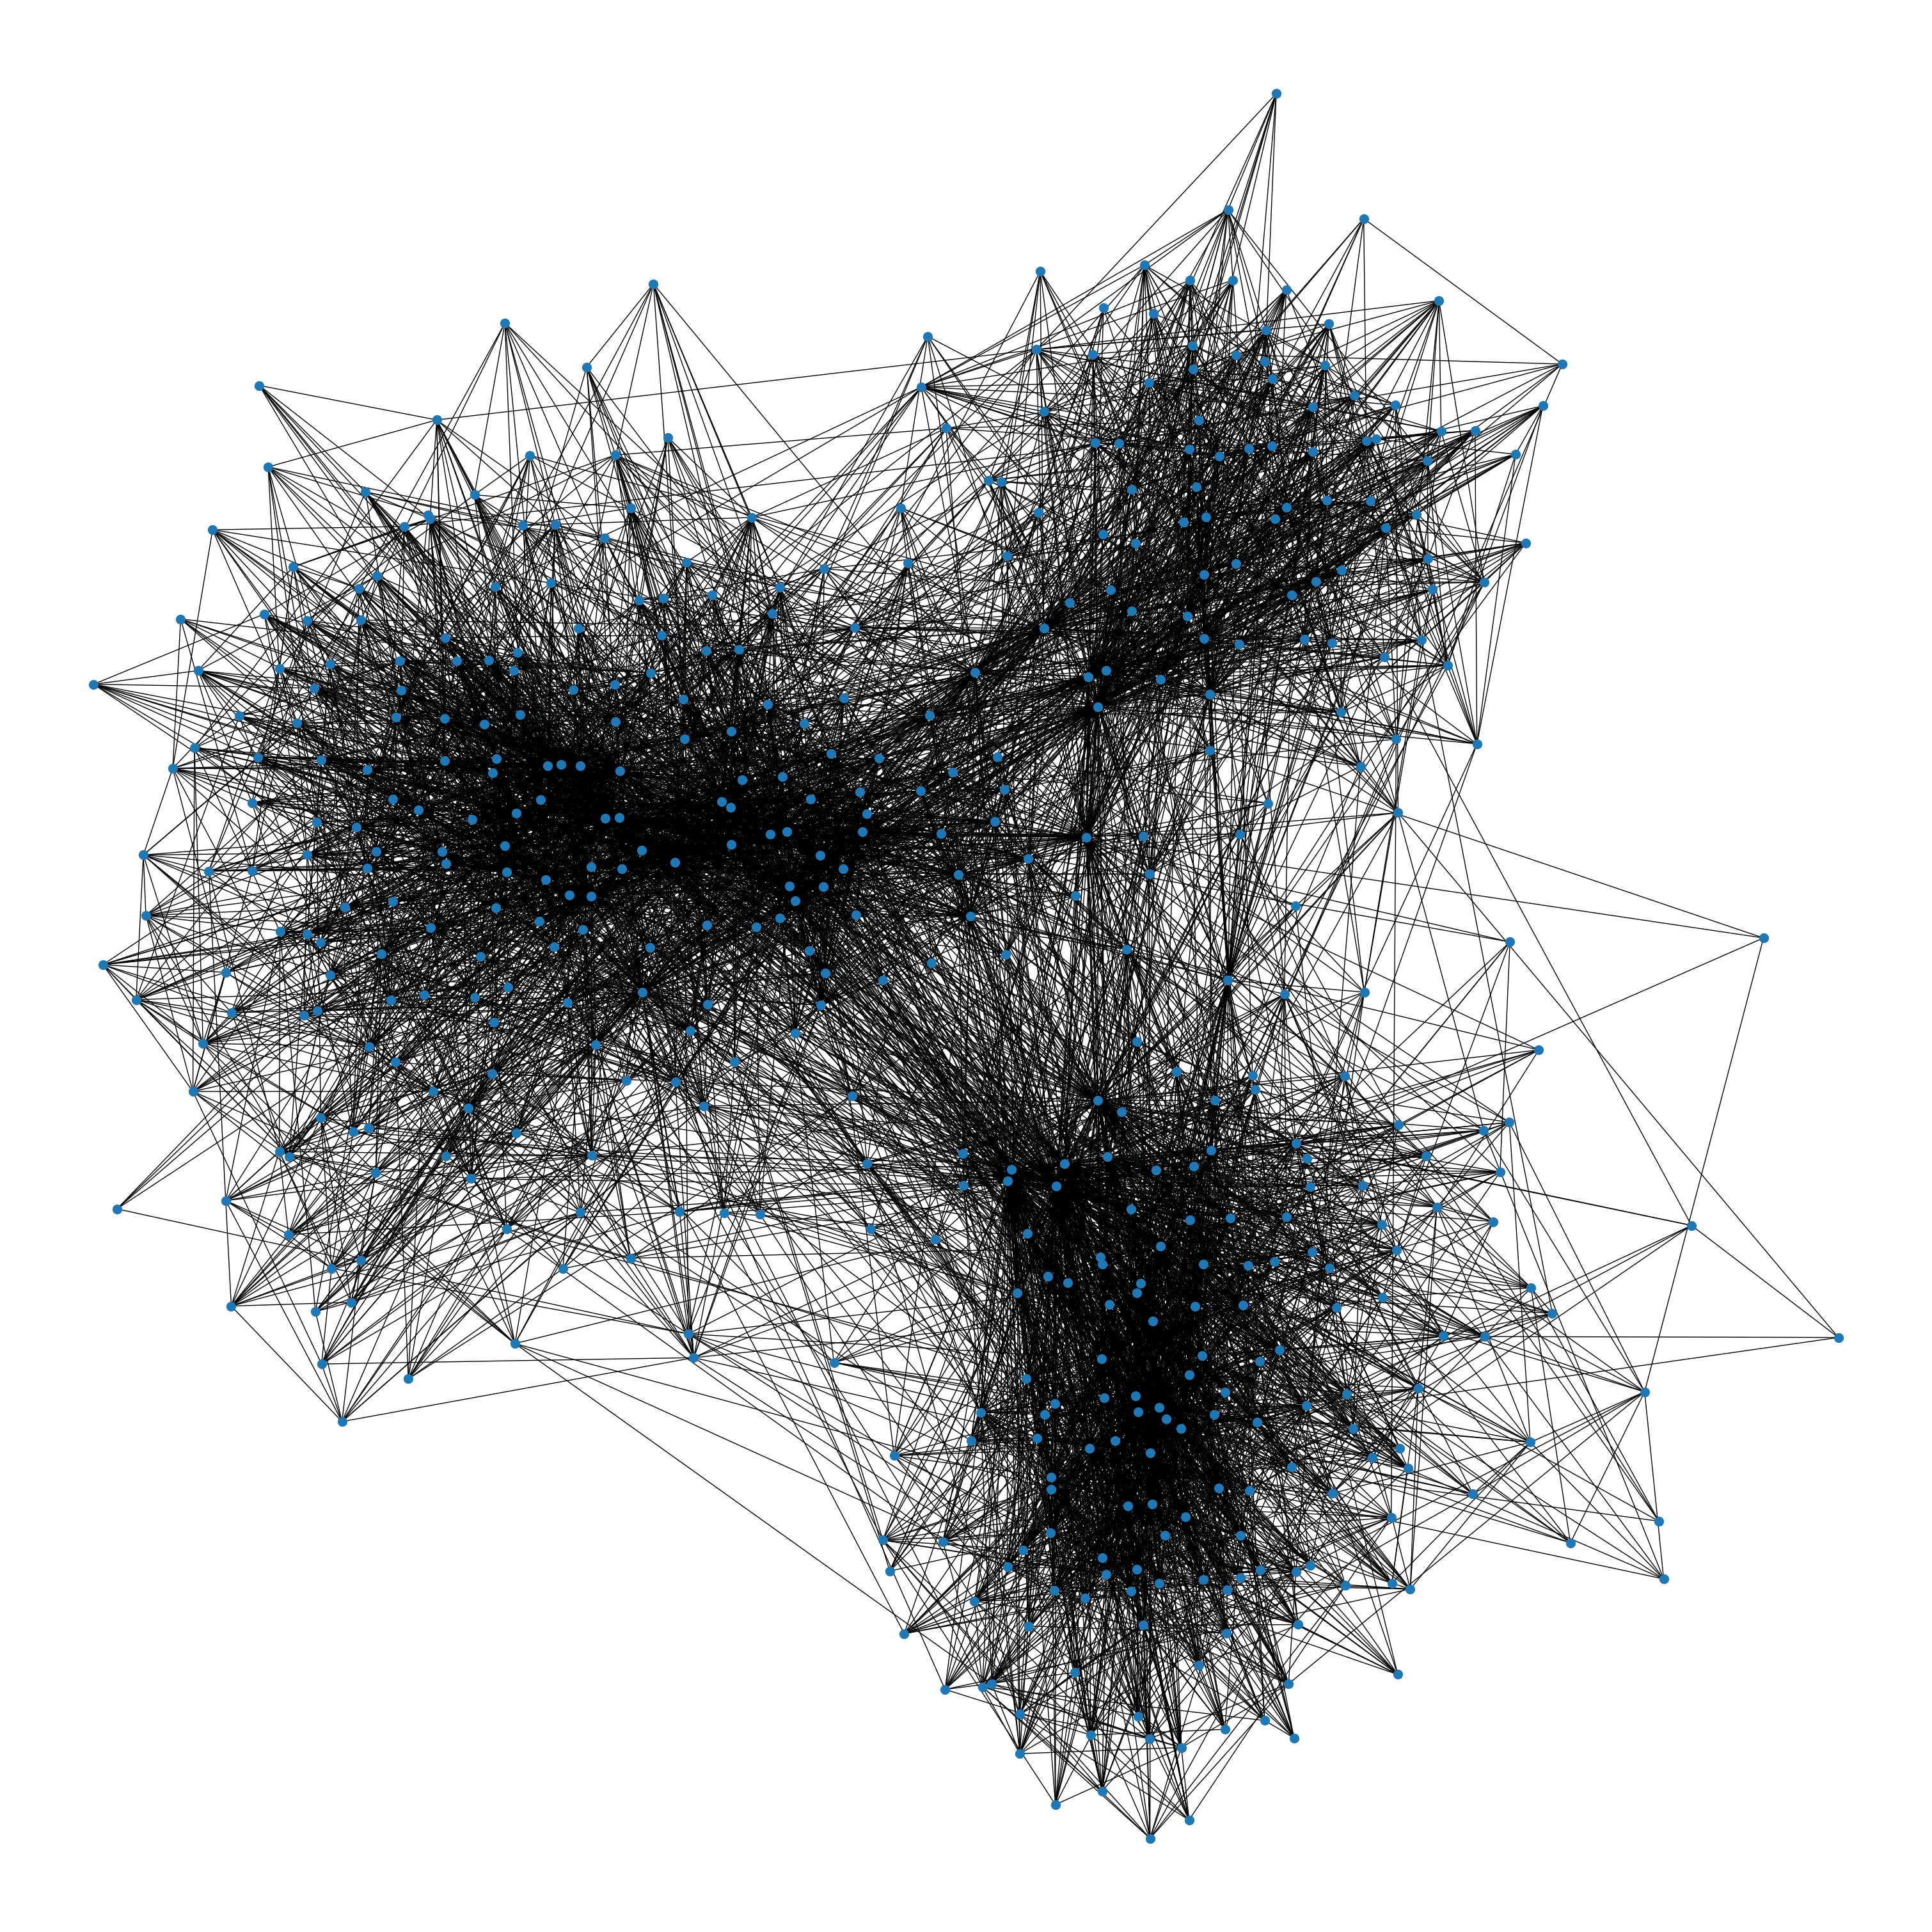

In [53]:
plot6 = plt.figure(6,figsize=(30,30), dpi=100)
nx.draw(G,node_size=100)
plt.show()

In [54]:
# Esto es las nuevos degrees que quedaron despues del filtro que hicimos
k = np.zeros(len(sliced))
for i in range(len(sliced)):
    k[i] = np.sum(sliced[i])

In [55]:
k_log = np.log(k)
m = np.mean(k_log)
s = np.std(k_log)
x = np.logspace(m-5*s,m+5*s,500) # Creo que esta mal hecha esta grid, pero abajo el xlim lo soluciona
y = np.exp(-(x-m)**2/(2*s**2))/np.sqrt(2*np.pi*s**2)

In [56]:
np.mean(k_log)

3.198130610811129

In [57]:
np.std(k_log)

0.6236846368520041

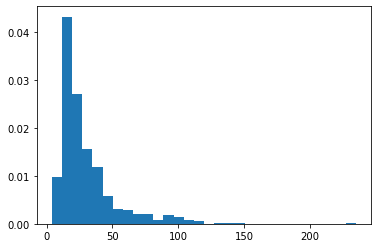

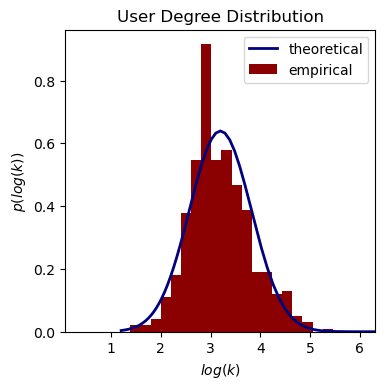

In [58]:
plt.hist(k,30,density=True)

plot6 = plt.figure(6,figsize=(4,4), dpi=100)
plt.hist(k_log,20,density=True, color="darkred", label = "empirical")
plt.plot(x,y,color="navy",linewidth = 2, label = "theoretical")
plt.xlim([m-5*s,m+5*s])
plt.xlabel("$log(k)$")
plt.ylabel("$p(log(k))$")
plt.title("User Degree Distribution")
plt.legend()
#plt.savefig('user-degree.png')


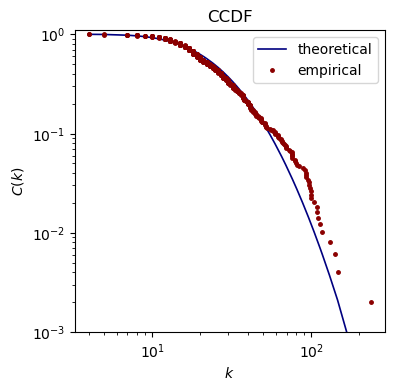

In [59]:
x = np.sort(k,axis=None); # Returns sorted in ascending order
y = np.arange(1,len(k)+1,1)
y = 1 - y/(len(k)+1); # Calculating CCDF as rank-frequency plot
c = 0.5*(1 - special.erf((np.log(x)-m)/(s*np.sqrt(2)))) # log-normal CCDF

plot6 = plt.figure(6,figsize=(4,4), dpi=100)
plt.plot(x,c,color='navy',linewidth=1.2, label = "theoretical")
plt.plot(x,y,".",color='darkred',markersize=5, label = "empirical")
plt.ylim([1e-3,1.1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$k$")
plt.ylabel("$C(k)$")
plt.title("CCDF")
plt.legend()
#plt.grid()
#plt.savefig('CCDF.png')

In [60]:
# We will use the k-s test to test if it is drawn from a gaussian distribution
# of course we use log(k) as if it was k because it is lognormal
a,b = stats.kstest(np.log(k)-m/s, 'norm') # By default "norm is mean 0 and std 1"
print(a,b)

0.7667235779403823 5.669265929170612e-304


In [61]:
# <<<<<<<<<<<<<<<<  Calculating centrality >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# The most intuitive way to think about this is the nodes that have higher degree, but there are different
# measures to calculate this, because it also matters that you are also conected with other very central nodes

central = np.zeros((10,2))
ind_sort = np.argsort(k)

for i in range(10):
    central[i][0] = ind_sort[-1-i]
    central[i][1] = k[ind_sort[-1-i]]

In [62]:
print("  index node  degree")
central

  index node  degree


array([[304., 235.],
       [ 48., 146.],
       [414., 140.],
       [ 10., 130.],
       [ 31., 117.],
       [244., 113.],
       [ 94., 110.],
       [ 12., 109.],
       [451., 108.],
       [330., 104.]])

In [63]:
from numpy import linalg as LA

L, V = LA.eig(sliced)

sorted_ind = np.argsort(L)
sorted_ind = np.flip(sorted_ind) # porque los queremos en descending order

L = L[sorted_ind]
V = np.transpose(V)
V = V[sorted_ind]

In [64]:
V1 = V[0]
sorted_ind = np.argsort(np.absolute(V1))
sorted_ind = np.flip(sorted_ind) # porque los queremos en descending order
print(sorted_ind[0])
V1 = V1[sorted_ind]

304


In [65]:
central_2 = np.zeros((10,2))
for i in range(10):
    central_2[i][0] = sorted_ind[i]
    central_2[i][1] = np.absolute(V1[i])

In [66]:
print("  index node  eig centrality")
central_2

  index node  eig centrality


array([[3.04000000e+02, 2.29503351e-01],
       [1.00000000e+01, 1.48257423e-01],
       [4.14000000e+02, 1.47494709e-01],
       [1.20000000e+01, 1.39701819e-01],
       [4.80000000e+01, 1.38864359e-01],
       [3.09000000e+02, 1.29798787e-01],
       [2.44000000e+02, 1.26385874e-01],
       [4.51000000e+02, 1.25803114e-01],
       [3.57000000e+02, 1.20950748e-01],
       [7.60000000e+01, 1.20647704e-01]])

In [67]:
df = pd.DataFrame(central_2,columns =["index node", "eig centrality"])
df["index node"] = df["index node"].astype(int)
df

index node  eig centrality
0         304        0.229503
1          10        0.148257
2         414        0.147495
3          12        0.139702
4          48        0.138864
5         309        0.129799
6         244        0.126386
7         451        0.125803
8         357        0.120951
9          76        0.120648

In [68]:
#<<<<<<<<<<<<<<<<<<<<<<<< Clustering Coefficient >>>>>>>>>>>>>>>>>>>

In [69]:
# Number of triangles each node participated in
T = np.diagonal(sliced.dot(sliced).dot(sliced)/2)
T = T.astype(int)

# Calculating clustering coefficients (proportion T/ all possible triangles that node i could have had)
C_coeff = 2*T/(k*(k-1))

In [70]:
C_coeff_df = pd.DataFrame(C_coeff)
C_coeff_df.to_csv('C_coeff.txt', index = False, header=False)

In [71]:
k_df = pd.DataFrame(k)
k_df.to_csv('degrees_k.txt', index = False, header=False)

In [72]:
# Nos fuimos a matlab, fitness doc para calcular xstar

In [73]:
# De matlab habias descargado k_null and C_coeff_null pero decidiste hacer algoritmo tu usando
# xstar solamente (alculada en matlab)

In [74]:
#<<<<<<<<<<<<<<<<<<<<<<<< Generating null models and testing properties of empirical network >>>>>>>>>>>>>>>>>>>

In [75]:
xstar_df = pd.read_csv('xstar.csv',header=None) # xstar.csv exportado de fitness matlab
xstar = xstar_df.to_numpy()
N = len(xstar)
xstar = np.reshape(xstar, N)

In [76]:
# Matrix of connectivity probabilities
P = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        P[i][j] = (xstar[i]*xstar[j])/(1+(xstar[i]*xstar[j]))

In [77]:
# We will generate 100 random networks
nmods = 100 # Number of independent null (random) models to be generated

k_null = np.zeros((nmods,N)) # Vector to store all degrees
C_coeff_null = np.zeros((nmods,N)) # Vector to store all clustering coefficients


for i in range(nmods):
    M = np.zeros((N,N))
    rand_M = np.random.rand(N,N)
    
    for j in range(N): # hicimos los indices asi para solo poner indices en lower triangular, porque es simetrica
        for b in range(j):
            if rand_M[j][b] < P[j][b]:
                M[j][b] = 1
            else:
                M[j][b] = 0

    M = M+np.transpose(M)  

    for m in range(N):
        k_null[i][m] = np.sum(M[m])
        
    T = np.diagonal(M.dot(M).dot(M)/2)
    C_coeff_null[i] = 2*T/(k_null[i]*(k_null[i]-1))

<ipython-input-77-3627cb800a6e>:25: RuntimeWarning: invalid value encountered in true_divide
  C_coeff_null[i] = 2*T/(k_null[i]*(k_null[i]-1))


In [78]:
# Fixing nan values
import math

for i in range(100):
    for j in range(N):
        if math.isnan(C_coeff_null[i][j]):
            C_coeff_null[i][j] = 100

In [79]:
k_index_sort = np.argsort(k)
sk = k[k_index_sort] # sorted degrees

sk_null = np.zeros((nmods,N))

for i in range(nmods):
    sk_null[i] = k_null[i][k_index_sort]
k_null_mean = np.mean(sk_null,axis=0)

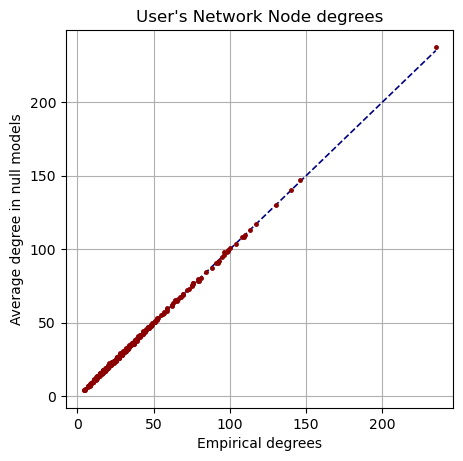

In [80]:
plot0 = plt.figure(0,figsize=(5,5), dpi=100)
plt.plot(sk,sk,"--",color='navy',linewidth=1.2)
plt.plot(sk,k_null_mean,".",color='darkred',markersize=5)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Empirical degrees")
plt.ylabel("Average degree in null models")
plt.title("User's Network Node degrees")
plt.grid()
#plt.savefig('null_degrees.png')

In [81]:
C_index_sort = np.argsort(C_coeff)
sC = C_coeff[C_index_sort] # sorted degrees

sC_null = np.zeros((nmods,N))

for i in range(nmods):
    sC_null[i] = C_coeff_null[i][C_index_sort]
C_null_mean = np.mean(sC_null,axis=0)

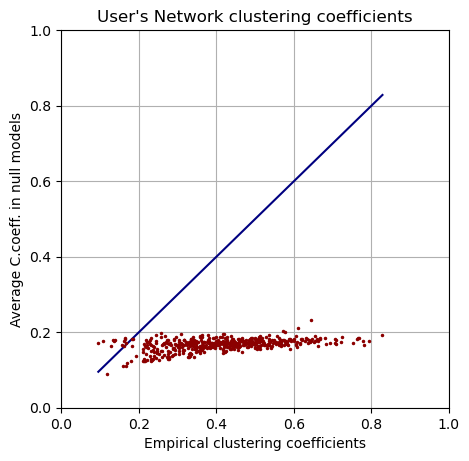

In [82]:
plot0 = plt.figure(0,figsize=(5,5), dpi=100)
plt.plot(sC,sC,"navy")
plt.plot(sC,C_null_mean,".",color='darkred',markersize=3)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim((0, 1)) # Te da un warning porque no hay log de 0
plt.ylim((0, 1))

plt.xlabel("Empirical clustering coefficients")
plt.ylabel("Average C.coeff. in null models")
plt.title("User's Network clustering coefficients")
plt.grid()
#plt.savefig('null_clustering.png')

In [83]:
C_coeff_mean = np.mean(C_coeff)

# Intervalo donde se encuantran 99% null (random) cluster coeff
null_Ccoeff_low = np.quantile(C_null_mean,0.005)
null_Ccoeff_high = np.quantile(C_null_mean,0.995)

print("Empirical average clustering coefficient: ", C_coeff_mean)
print("99% CL interval in null models: [", null_Ccoeff_low,", ",null_Ccoeff_high,"]")

Empirical average clustering coefficient:  0.41162781558203987
99% CL interval in null models: [ 0.11450956497170539 ,  4.824773203463267 ]


In [84]:
np.mean(C_null_mean)

0.23704131803803175